In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification


ModuleNotFoundError: No module named 'pandas'

In [ ]:
import pandas as pd

df = pd.read_csv("datasetTelegram.csv")
df.head()


Mounted at /content/drive


,_,id,peer_id,date,message,out,mentioned,media_unread,silent,post,...,grouped_id,reactions,restriction_reason,ttl_period,quick_reply_shortcut_id,effect,factcheck,report_delivery_until_date,action,reactions_are_possible
0,Message,124905,[object Object],2025-03-24T13:25:10+00:00,NaN,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Message,124904,[object Object],2025-03-24T08:29:37+00:00,NaN,False,False,False,False,False,...,1.394244e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Message,124903,[object Object],2025-03-24T08:29:37+00:00,NaN,False,False,False,False,False,...,1.394244e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Message,124902,[object Object],2025-03-24T05:02:56+00:00,Permisi. \nSaya lagi mencari akun google Play ...,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Message,124901,[object Object],2025-03-24T02:24:55+00:00,🙌 Hai Sobat Juaraaa! 🙌\n\nJuaraCoding is comin...,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
selected_columns = [
    'id', 'date', 'message', 'from_id',
    'entities', 'views', 'forwards', 'reactions', 'action'
]
df = df[selected_columns].dropna(subset=['message'])

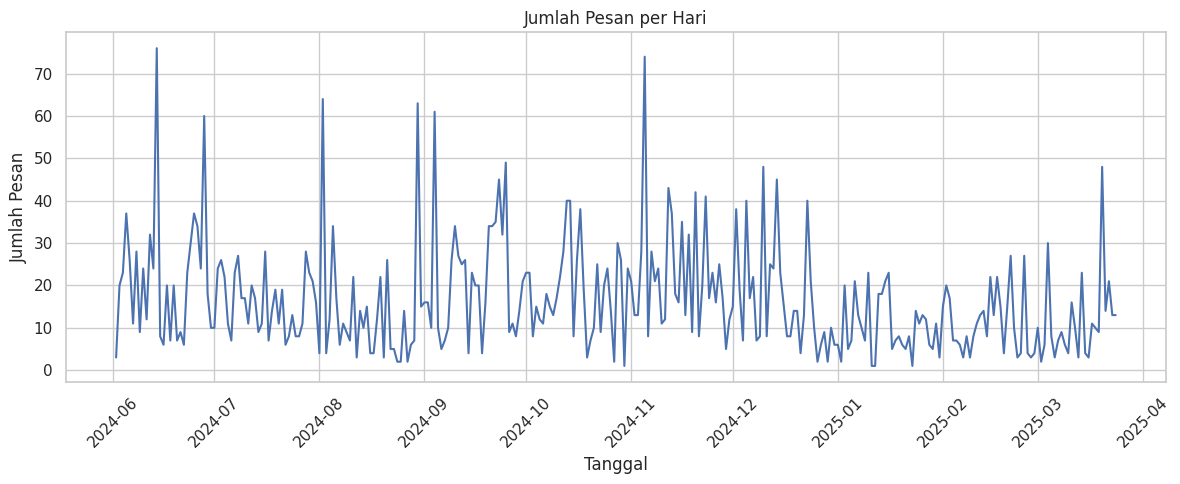

/tmp/ipython-input-1477159954.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='viridis')


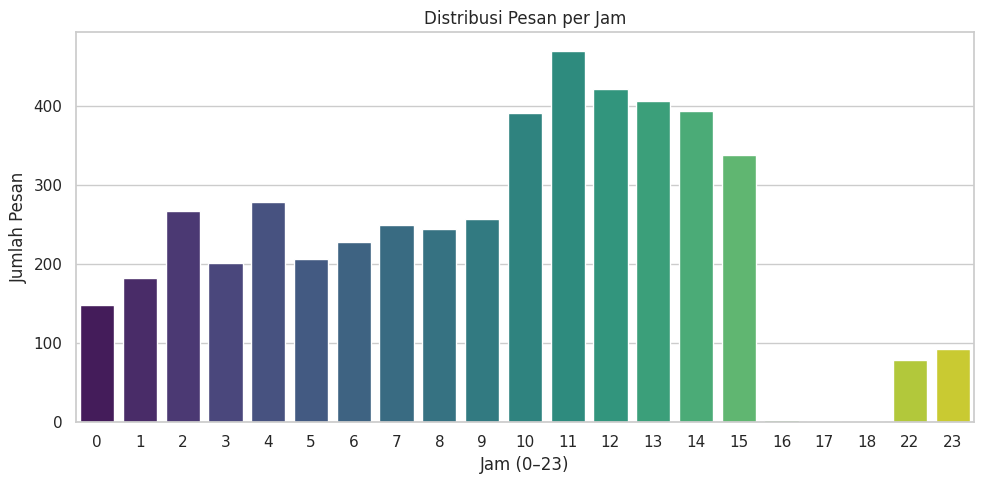

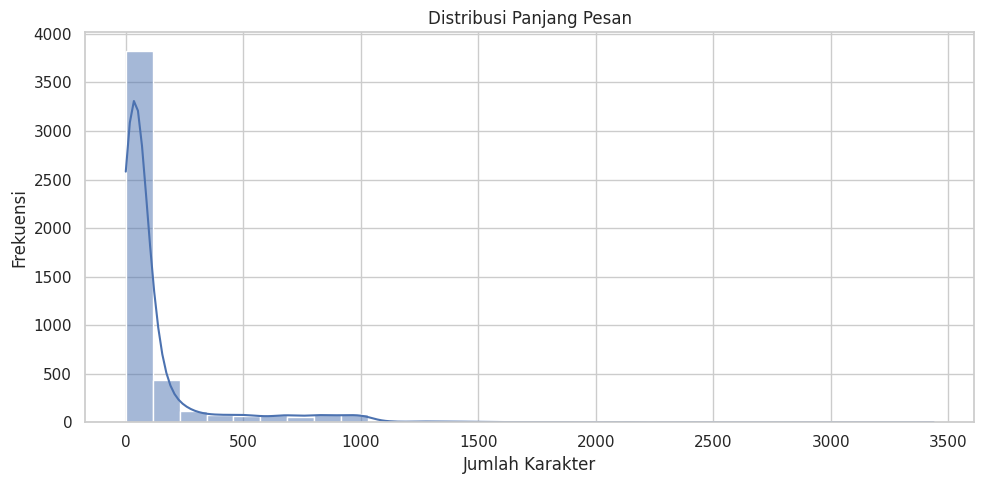

In [ ]:
save_path = "/content/drive/MyDrive/nlp"


df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['hour'] = df['date'].dt.hour
df['message_length'] = df['message'].astype(str).apply(len)

# Style
sns.set(style="whitegrid")

# 1. Jumlah pesan per hari
plt.figure(figsize=(12, 5))
df['date'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title("Jumlah Pesan per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Pesan")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "message_dist.png"))  # Simpan ke Drive
plt.show()

# 2. Distribusi pesan per jam
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df, palette='viridis')
plt.title("Distribusi Pesan per Jam")
plt.xlabel("Jam (0–23)")
plt.ylabel("Jumlah Pesan")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "hour_dist.png"))
plt.show()

# 3. Distribusi panjang pesan
plt.figure(figsize=(10, 5))
sns.histplot(df['message_length'], bins=30, kde=True)
plt.title("Distribusi Panjang Pesan")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "length_dist.png"))
plt.show()


Preprocesing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['message'].apply(preprocess)
pd.set_option('display.max_colwidth', None)
df[['id', 'date', 'message', 'clean_text']].head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,date,message,clean_text
3,124902,2025-03-24 05:02:56+00:00,"Permisi. \nSaya lagi mencari akun google Play console aktif, closed/ditutup maupun telat verifikasi.\nSaya siap membeli rate harga 1-12jt\nTransaksi siap COD ataupun rekber. \n\nWA 087857174124\nTerima kasih 🙏",permisi mencari akun googl play consol aktif closedditutup telat verifikasi memb rate harga jt transaksi cod rekber wa terima kasih
4,124901,2025-03-24 02:24:55+00:00,"🙌 Hai Sobat Juaraaa! 🙌\n\nJuaraCoding is coming back! 🤩🤩\n\nKelas yang dibuka kali ini adalah Kelas JavaBackend Batch 25.\n\n📚 Kelas ini akan mempelajari mengenai :\n1. Java Fundamental\n2. SQL Fundamental\n3. Java Backend Springboot\n4. Web Java\n\nPelatihan ini akan dimulai pada :\n🗓 Senin, 24 Maret 2025\n\n⏱ Dengan durasi : 09 Minggu Pelatihan.\n\nBenefit yang akan kamu dapatkan diantaranya :\n🏋 Dilatih oleh trainer bersertifikat BNSP\n👨🏻‍💻 Mendukung kesiapan karir\n💻 Live Coding Mentoring\n💼 Interview Skill Coaching\n🖥 Real Project\n\nTunggu apalagi? Jangan sampai ketinggalan, yuk daftar sekarang! 🙌🙌🙌\n\nMore Info :\n📩 luis.fernando@ptdika.com\n📲 Louis : 089630152618\n\nJuara Coding, Grow People Through Learning!",hai sobat juaraaa juaracod is come back kela dibuka kali kela javabackend batch kela mempelajari java fundament sql fundament java backend springboot web java pelatihan senin maret durasi minggu pelatihan benefit dapatkan dilatih trainer bersertifikat bnsp mendukung kesiapan karir live code mentor interview skill coach real project tunggu ketinggalan yuk daftar more info luisfernandoptdikacom loui juara code grow peopl through learn
5,124900,2025-03-24 02:03:39+00:00,"📢📢𝙋𝙀𝙉𝙂𝙐𝙈𝙐𝙈𝘼𝙉 𝙋𝙐𝘽𝙇𝙄𝙆𝘼𝙎𝙄 𝙅𝙐𝙍𝙉𝘼𝙇 𝙄𝙉𝙏𝙀𝙍𝙉𝘼𝙎𝙄𝙊𝙉𝘼𝙇!!!!!\n\n🗣️Halo Bapak / Ibu Dosen dan Mahasiswa. Dapatkan kesempatan untuk menerbitkan artikel Anda di jurnal internasional terkemuka:\n\n🌎Jurnal Internasional 🌎\nInternational Journal of Applied and Advanced Multidisciplinary Research (IJAAMR)\n- Terbitan Maret \n- Link Journal: https://jurnalinternasional.com/index.php/ijaamr\n\n🤝Keuntungan Menerbitkan Artikel\n✓Meningkatkan reputasi dan kredibilitas Anda sebagai penulis\n✓Menambah informasi di Curriculum Vitae\n✓Dapat digunakan untuk kum PAK & BKD bagi Dosen\n✓DOI teraktivasi\n✓Terindex : Google Scholar, Dimensions, Directory of Research Journals Indexing, CrossRef, Research Bible, GARUDA, BASE (Bielefeld Academic Search Engine), WorldCat, Scilit, IUPUI Libraries, Semantic Scholar, Citefactor, Eurasian Scientific Journal Index\n✓LOA 3-10 hari\n\n💵Biaya Publikasi\n- Reguler Rp 300.000/artikel (free translate)\n\nUntuk informasi lebih lanjut, \n📞Kontak Kami\n- WA:\n+6287880415039\n+6287880415039\n+6287880415039\n\n https://wa.me/+6287880415039",halo dosen mahasiswa dapatkan kesempatan menerbitkan artikel jurnal internasion terkemuka jurnal internasion intern journal of appli and advanc multidisciplinari research ijaamr terbitan maret link journal httpsjurnalinternasionalcomindexphpijaamr keuntungan menerbitkan artikel meningkatkan reputasi kredibilita penuli menambah informasi curriculum vita kum bkd dosen doi teraktivasi terindex googl scholar dimens directori of research journal index crossref research bibl garuda base bielefeld academ search engin worldcat scilit iupui librari semant scholar citefactor eurasian scientif journal index loa biaya publikasi regul rp artikel free translat informasi kontak wa httpswame
6,124899,2025-03-24 02:03:10+00:00,"📢📢𝙋𝙀𝙉𝙂𝙐𝙈𝙐𝙈𝘼𝙉 𝙋𝙐𝘽𝙇𝙄𝙆𝘼𝙎𝙄 𝙅𝙐𝙍𝙉𝘼𝙇 𝙄𝙉𝙏𝙀𝙍𝙉𝘼𝙎𝙄𝙊𝙉𝘼𝙇!!!!!\n\n🗣️Halo Bapak / Ibu Dosen dan Mahasiswa. Dapatkan kesempatan untuk menerbitkan artikel Anda di jurnal internasional terkemuka:\n\n🌎Jurnal Internasional 🌎\nInternational Journal of Applied and Advanced Multidisciplinary Research (IJAAMR)\n- Terbitan Maret \n- Link Journal: https://jurnalinternasional.com/index.php/ijaamr\n\n🤝Keuntungan Menerbitkan Artikel\n✓Meningkatkan reputasi dan kredibilitas Anda sebagai penulis\n✓Menambah informasi di Curriculum Vitae\n✓Dapat digunakan untuk kum PAK & BKD bagi Dosen\n✓DOI teraktivasi\n✓T

LEBEL

In [ ]:
# Fungsi labeling untuk teks yang sudah diproses
def label_spam_processed(processed_text):
    if not processed_text or not isinstance(processed_text, str):
        return 0

    # Kata kunci spam setelah diproses (stemmed)
    spam_keywords = {
        # Commercial
        'promo', 'diskon', 'deal', 'offer', 'beli', 'order', 'shop',
        'jual', 'vouch', 'cashback', 'harga', 'murah',

        # Financial
        'pinjam', 'kredit', 'uang', 'duit', 'invest', 'profit',

        # Giveaway
        'menang', 'hadiah', 'reward', 'giveaway', 'undian', 'klaim',

        # Links
        'http', 'www', 'com', 'click', 'link', 'url', 'bitly', 'googl',

        # Adult
        'dewasa', 'dating', 'single', 'meet', 'sexi', 'hot',

        # Produk ilegal
        'obat', 'resep', 'pelangsing', 'viagra'
    }

    # Pola khusus untuk teks yang sudah diproses
    patterns = {
        'excessive_repeats': re.compile(r'(\b\w+\b)(?:\s+\1){2,}'),  # Kata berulang
        'strange_combos': re.compile(r'\b[a-z]{1,2}\d+[a-z]*\b'),  # Kombinasi aneh
    }

    tokens = set(processed_text.split())

    # Kriteria spam
    criteria = [
        # Keyword spam ada dalam teks
        len(tokens & spam_keywords) > 0,

        # Minimal 3 kata unik (untuk hindari spam pendek)
        len(tokens) < 3,

        # Pola mencurigakan
        any(pattern.search(processed_text) for pattern in patterns.values()),

        # Banyak kata pendek tidak wajar
        sum(1 for word in processed_text.split() if len(word) < 3) / len(processed_text.split()) > 0.5
        if len(processed_text.split()) > 0 else False,
    ]

    # Jika memenuhi minimal 1 kriteria, anggap spam
    if sum(criteria) >= 1:
        return 1

    return 0

# Contoh implementasi
df['clean_text'] = df['message'].apply(preprocess)
df['label'] = df['clean_text'].apply(label_spam_processed)
#simpan hasil lebeling
output_csv_path = os.path.join(save_path, "hasil_labeling_spam.csv")
df[['id', 'date', 'message', 'clean_text', 'label']].to_csv(output_csv_path, index=False)
# Tampilkan hasil
pd.set_option('display.max_colwidth', None)
df[['id', 'date', 'message', 'clean_text', 'label']].head(10)



,id,date,message,clean_text,label
3,124902,2025-03-24 05:02:56+00:00,"Permisi. \nSaya lagi mencari akun google Play console aktif, closed/ditutup maupun telat verifikasi.\nSaya siap membeli rate harga 1-12jt\nTransaksi siap COD ataupun rekber. \n\nWA 087857174124\nTerima kasih 🙏",permisi mencari akun googl play consol aktif closedditutup telat verifikasi memb rate harga jt transaksi cod rekber wa terima kasih,1
4,124901,2025-03-24 02:24:55+00:00,"🙌 Hai Sobat Juaraaa! 🙌\n\nJuaraCoding is coming back! 🤩🤩\n\nKelas yang dibuka kali ini adalah Kelas JavaBackend Batch 25.\n\n📚 Kelas ini akan mempelajari mengenai :\n1. Java Fundamental\n2. SQL Fundamental\n3. Java Backend Springboot\n4. Web Java\n\nPelatihan ini akan dimulai pada :\n🗓 Senin, 24 Maret 2025\n\n⏱ Dengan durasi : 09 Minggu Pelatihan.\n\nBenefit yang akan kamu dapatkan diantaranya :\n🏋 Dilatih oleh trainer bersertifikat BNSP\n👨🏻‍💻 Mendukung kesiapan karir\n💻 Live Coding Mentoring\n💼 Interview Skill Coaching\n🖥 Real Project\n\nTunggu apalagi? Jangan sampai ketinggalan, yuk daftar sekarang! 🙌🙌🙌\n\nMore Info :\n📩 luis.fernando@ptdika.com\n📲 Louis : 089630152618\n\nJuara Coding, Grow People Through Learning!",hai sobat juaraaa juaracod is come back kela dibuka kali kela javabackend batch kela mempelajari java fundament sql fundament java backend springboot web java pelatihan senin maret durasi minggu pelatihan benefit dapatkan dilatih trainer bersertifikat bnsp mendukung kesiapan karir live code mentor interview skill coach real project tunggu ketinggalan yuk daftar more info luisfernandoptdikacom loui juara code grow peopl through learn,0
5,124900,2025-03-24 02:03:39+00:00,"📢📢𝙋𝙀𝙉𝙂𝙐𝙈𝙐𝙈𝘼𝙉 𝙋𝙐𝘽𝙇𝙄𝙆𝘼𝙎𝙄 𝙅𝙐𝙍𝙉𝘼𝙇 𝙄𝙉𝙏𝙀𝙍𝙉𝘼𝙎𝙄𝙊𝙉𝘼𝙇!!!!!\n\n🗣️Halo Bapak / Ibu Dosen dan Mahasiswa. Dapatkan kesempatan untuk menerbitkan artikel Anda di jurnal internasional terkemuka:\n\n🌎Jurnal Internasional 🌎\nInternational Journal of Applied and Advanced Multidisciplinary Research (IJAAMR)\n- Terbitan Maret \n- Link Journal: https://jurnalinternasional.com/index.php/ijaamr\n\n🤝Keuntungan Menerbitkan Artikel\n✓Meningkatkan reputasi dan kredibilitas Anda sebagai penulis\n✓Menambah informasi di Curriculum Vitae\n✓Dapat digunakan untuk kum PAK & BKD bagi Dosen\n✓DOI teraktivasi\n✓Terindex : Google Scholar, Dimensions, Directory of Research Journals Indexing, CrossRef, Research Bible, GARUDA, BASE (Bielefeld Academic Search Engine), WorldCat, Scilit, IUPUI Libraries, Semantic Scholar, Citefactor, Eurasian Scientific Journal Index\n✓LOA 3-10 hari\n\n💵Biaya Publikasi\n- Reguler Rp 300.000/artikel (free translate)\n\nUntuk informasi lebih lanjut, \n📞Kontak Kami\n- WA:\n+6287880415039\n+6287880415039\n+6287880415039\n\n https://wa.me/+6287880415039",halo dosen mahasiswa dapatkan kesempatan menerbitkan artikel jurnal internasion terkemuka jurnal internasion intern journal of appli and advanc multidisciplinari research ijaamr terbitan maret link journal httpsjurnalinternasionalcomindexphpijaamr keuntungan menerbitkan artikel meningkatkan reputasi kredibilita penuli menambah informasi curriculum vita kum bkd dosen doi teraktivasi terindex googl scholar dimens directori of research journal index crossref research bibl garuda base bielefeld academ search engin worldcat scilit iupui librari semant scholar citefactor eurasian scientif journal index loa biaya publikasi regul rp artikel free translat informasi kontak wa httpswame,1
6,124899,2025-03-24 02:03:10+00:00,"📢📢𝙋𝙀𝙉𝙂𝙐𝙈𝙐𝙈𝘼𝙉 𝙋𝙐𝘽𝙇𝙄𝙆𝘼𝙎𝙄 𝙅𝙐𝙍𝙉𝘼𝙇 𝙄𝙉𝙏𝙀𝙍𝙉𝘼𝙎𝙄𝙊𝙉𝘼𝙇!!!!!\n\n🗣️Halo Bapak / Ibu Dosen dan Mahasiswa. Dapatkan kesempatan untuk menerbitkan artikel Anda di jurnal internasional terkemuka:\n\n🌎Jurnal Internasional 🌎\nInternational Journal of Applied and Advanced Multidisciplinary Research (IJAAMR)\n- Terbitan Maret \n- Link Journal: https://jurnalinternasional.com/index.php/ijaamr\n\n🤝Keuntungan Menerbitkan Artikel\n✓Meningkatkan reputasi dan kredibilitas Anda sebagai penulis\n✓Menambah informasi di Curriculum Vitae\n✓Dapat digunakan untuk kum PAK & BKD bagi Dosen\n✓DOI ter

In [ ]:
df['label'] = df['label'].astype(int)

print(df['label'].value_counts())


label
0    3391
1    1474
Name: count, dtype: int64


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

num_labels = df['label'].nunique()
print("Jumlah kelas:", num_labels)


Jumlah kelas: 2


#LSTM (NON-PRETRAINED)

In [108]:
keras_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(X_train)

X_train_seq = keras_tokenizer.texts_to_sequences(X_train)
X_test_seq = keras_tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    LSTM(128),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.6854 - loss: 0.6302 - val_accuracy: 0.6974 - val_loss: 0.6127
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.6999 - loss: 0.6137 - val_accuracy: 0.7026 - val_loss: 0.6118
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.6970 - loss: 0.6180 - val_accuracy: 0.7000 - val_loss: 0.6113
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.7072 - loss: 0.6081 - val_accuracy: 0.7026 - val_loss: 0.6050
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.7003 - loss: 0.6182 - val_accuracy: 0.7000 - val_loss: 0.6108


In [ ]:
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)

print("LSTM Classification Report")
print(classification_report(y_test, y_pred_lstm))


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
LSTM Classification Report
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       678
           1       1.00      0.01      0.02       295

    accuracy                           0.70       973
   macro avg       0.85      0.51      0.42       973
weighted avg       0.79      0.70      0.58       973



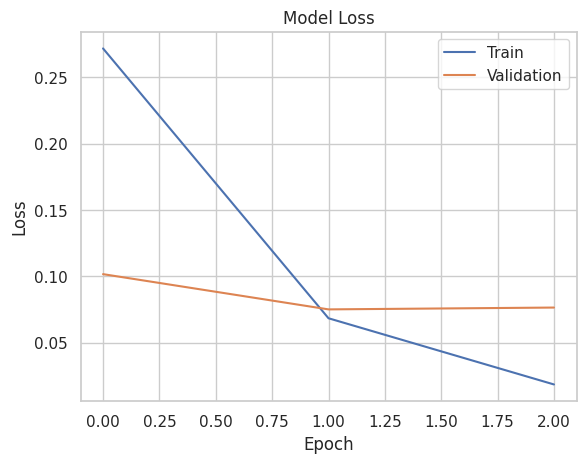

In [68]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train', 'Validation'])
plt.show()


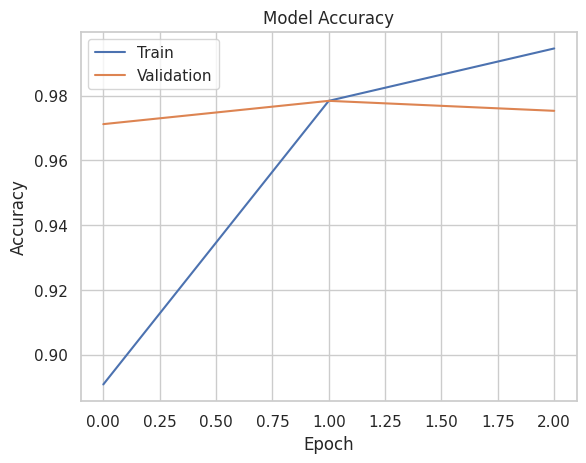

In [69]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


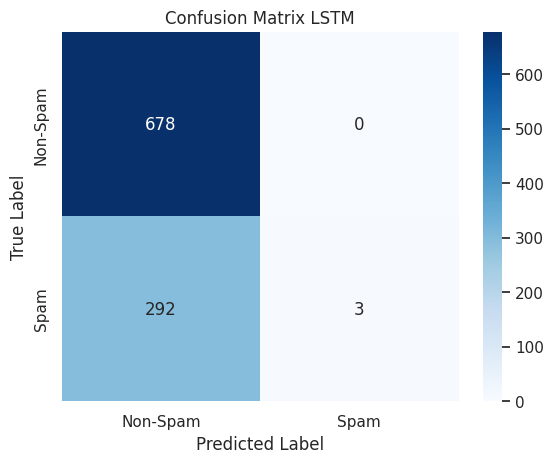

In [70]:
cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-Spam', 'Spam'],
    yticklabels=['Non-Spam', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix LSTM')
plt.show()


#IndoBERT

In [ ]:
!pip install transformers datasets -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 33.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf"
)

test_encodings = tokenizer(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf"
)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
)).shuffle(1000).batch(16)




In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import create_optimizer
import tensorflow as tf

num_train_steps = len(train_dataset) * 3  # 3 epoch

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [66]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3
)


Epoch 1/3
244/244 [==============================] - 6705s 27s/step - loss: 0.2718 - accuracy: 0.8908 - val_loss: 0.1017 - val_accuracy: 0.9712
Epoch 2/3
244/244 [==============================] - 6604s 27s/step - loss: 0.0684 - accuracy: 0.9784 - val_loss: 0.0751 - val_accuracy: 0.9784
Epoch 3/3
244/244 [==============================] - 6559s 27s/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.0765 - val_accuracy: 0.9753


In [67]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

logits = model.predict(test_dataset).logits
y_pred = np.argmax(logits, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


61/61 [==============================] - 504s 8s/step
[[669   9]
 [ 15 280]]
              precision    recall  f1-score   support

           0     0.9781    0.9867    0.9824       678
           1     0.9689    0.9492    0.9589       295

    accuracy                         0.9753       973
   macro avg     0.9735    0.9679    0.9706       973
weighted avg     0.9753    0.9753    0.9753       973



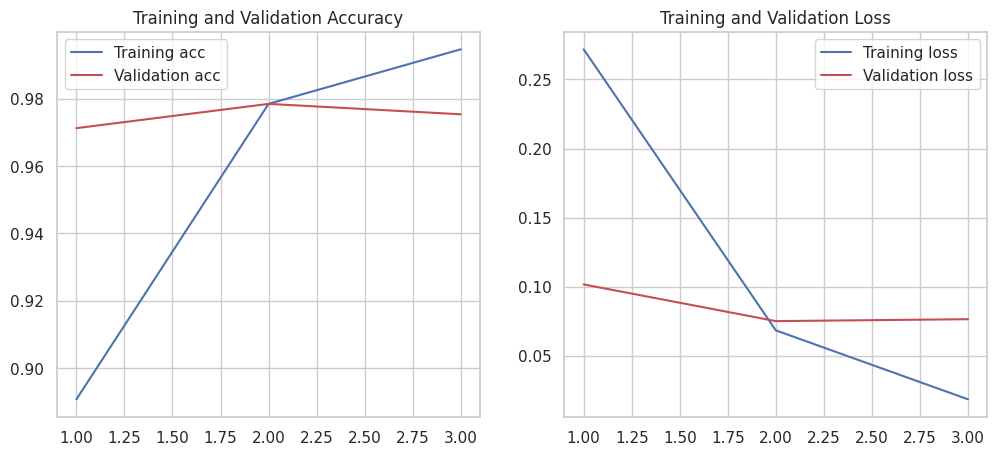

In [71]:
# Asumsi: history = model.fit(...) atau trainer.train()

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

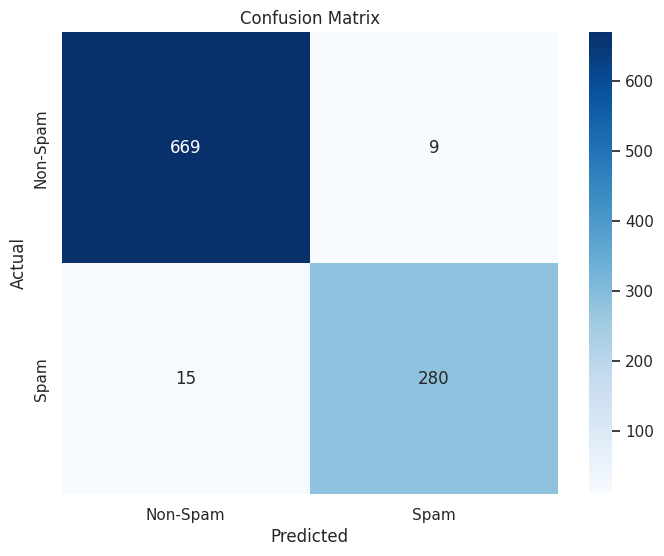

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define label names for the confusion matrix
label_names = ['Non-Spam', 'Spam']

# Visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Universal Sentence Encoder (USE)

In [102]:
import tensorflow_hub as hub
import tensorflow as tf

# Load model Universal Sentence Encoder dari TF Hub
# Model ini mengubah kalimat langsung menjadi vector 512 dimensi
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def get_embeddings(texts):
    return embed(texts)

# Karena USE butuh input teks langsung, kita gunakan X_train dan X_test (bukan pad_sequences)
X_train_use = get_embeddings(X_train)
X_test_use = get_embeddings(X_test)

In [103]:
model_use = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,), dtype=tf.float32),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax') # 2 kelas: spam & non-spam
])

model_use.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training model (Sangat cepat karena tidak ada proses tokenisasi manual)
history_use = model_use.fit(
    X_train_use, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_use, y_test)
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7690 - loss: 0.4941 - val_accuracy: 0.8839 - val_loss: 0.2833
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8932 - loss: 0.2627 - val_accuracy: 0.8849 - val_loss: 0.2668
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9159 - loss: 0.2081 - val_accuracy: 0.8972 - val_loss: 0.2718
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9391 - loss: 0.1663 - val_accuracy: 0.9003 - val_loss: 0.2484
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9518 - loss: 0.1398 - val_accuracy: 0.9034 - val_loss: 0.2714
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9635 - loss: 0.1126 - val_accuracy: 0.9044 - val_loss: 0.2755
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9647 - loss: 0.0894 - val_accuracy: 0.9044 - val_loss: 0.3159
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9707 - loss: 0.0779 - val_accuracy:

In [104]:
y_pred_use = np.argmax(model_use.predict(X_test_use), axis=1)

print("=== Universal Sentence Encoder Report ===")
print(classification_report(y_test, y_pred_use))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
=== Universal Sentence Encoder Report ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       678
           1       0.87      0.83      0.85       295

    accuracy                           0.91       973
   macro avg       0.90      0.89      0.89       973
weighted avg       0.91      0.91      0.91       973



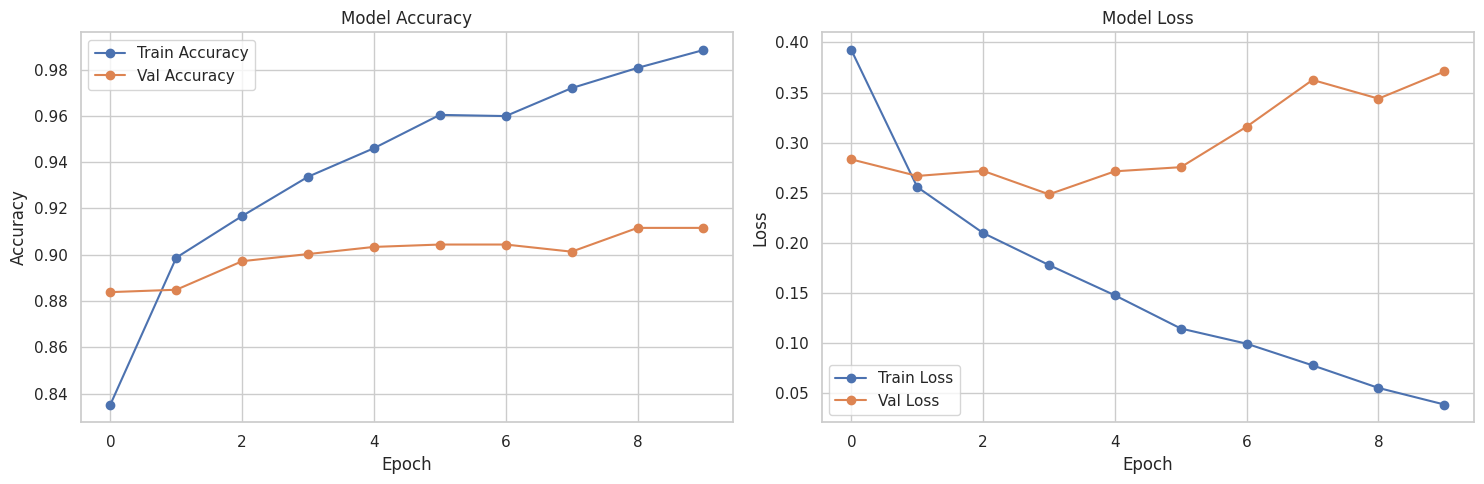

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Grafik Accuracy
ax1.plot(history_use.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history_use.history['val_accuracy'], label='Val Accuracy', marker='o')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Grafik Loss
ax2.plot(history_use.history['loss'], label='Train Loss', marker='o')
ax2.plot(history_use.history['val_loss'], label='Val Loss', marker='o')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

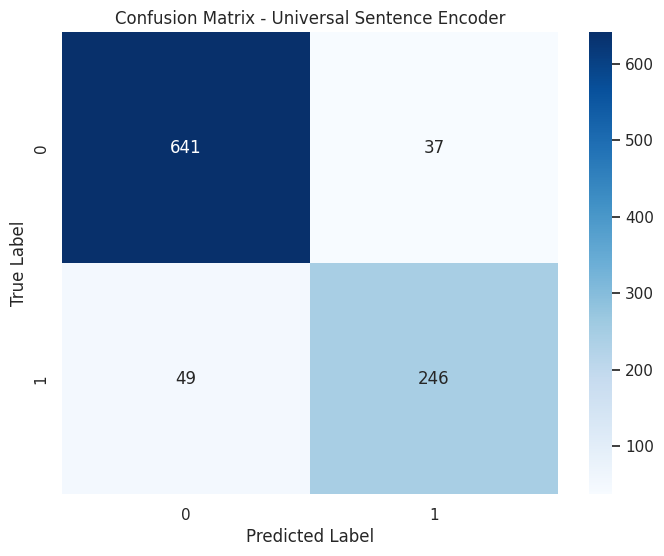

In [106]:
plt.figure(figsize=(8, 6))
cm_use = confusion_matrix(y_test, y_pred_use)
sns.heatmap(cm_use, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Universal Sentence Encoder')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()